In [2]:
# for cold
mannual_pathways = [
#ACC
"MSigDB_Hallmark_2020__G2-M Checkpoint",
"MSigDB_Hallmark_2020__E2F Targets",

#BRCA
"Reactome_2022__Keratinization R-HSA-6805567",
"KEGG_2021_Human__Regulation of lipolysis in adipocytes",

# COADREAD
"MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition",

#GBMLGG
"KEGG_2021_Human__Viral protein interaction with cytokine and cytokine receptor",
"Reactome_2022__Interleukin-10 Signaling R-HSA-6783783",
"MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB",

#HNSC
"Reactome_2022__Formation Of Cornified Envelope R-HSA-6809371",

# LUAD
"KEGG_2021_Human__Bacterial invasion of epithelial cells",
"Reactome_2022__Keratinization R-HSA-6805567",
"MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB",
"Reactome_2022__MET Activates PTK2 Signaling R-HSA-8874081",

# MESO
"KEGG_2021_Human__Oxidative phosphorylation",
"Reactome_2022__Respiratory Electron Transport R-HSA-611105",

# OV
"Reactome_2022__Formation Of A Pool Of Free 40S Subunits R-HSA-72689",

#PAAD
"KEGG_2021_Human__Protein processing in endoplasmic reticulum",

# PRAD
"Reactome_2022__Striated Muscle Contraction R-HSA-390522",

#TGCT
"Reactome_2022__rRNA Processing R-HSA-72312",
"Reactome_2022__Response Of EIF2AK4 (GCN2) To Amino Acid Deficiency R-HSA-9633012",

# UCS
"Reactome_2022__Selenocysteine Synthesis R-HSA-2408557",
"Reactome_2022__Eukaryotic Translation Termination R-HSA-72764",

]

Top 20 common names: ['Reactome_2022__Mitotic Anaphase R-HSA-68882', 'Reactome_2022__S Phase R-HSA-69242', 'MSigDB_Hallmark_2020__E2F Targets', 'MSigDB_Hallmark_2020__G2-M Checkpoint', 'Reactome_2022__Resolution Of Sister Chromatid Cohesion R-HSA-2500257', 'Reactome_2022__Ubiquitin-dependent Degradation Of Cyclin D R-HSA-75815', 'Reactome_2022__Regulation Of APC/C Activators Between G1/S And Early Anaphase R-HSA-176408', 'Reactome_2022__Centrosome Maturation R-HSA-380287', 'Reactome_2022__Mitotic Spindle Checkpoint R-HSA-69618', 'Reactome_2022__Unattached Kinetochores Signal Amplification Via A MAD2 Inhibitory Signal R-HSA-141444', 'Reactome_2022__Loss Of Nlp From Mitotic Centrosomes R-HSA-380259', 'Reactome_2022__DNA Replication R-HSA-69306', 'KEGG_2021_Human__Fanconi anemia pathway', 'Reactome_2022__DNA Strand Elongation R-HSA-69190', 'MSigDB_Hallmark_2020__Allograft Rejection', 'MSigDB_Hallmark_2020__Inflammatory Response', 'KEGG_2021_Human__Bacterial invasion of epithelial cells', 

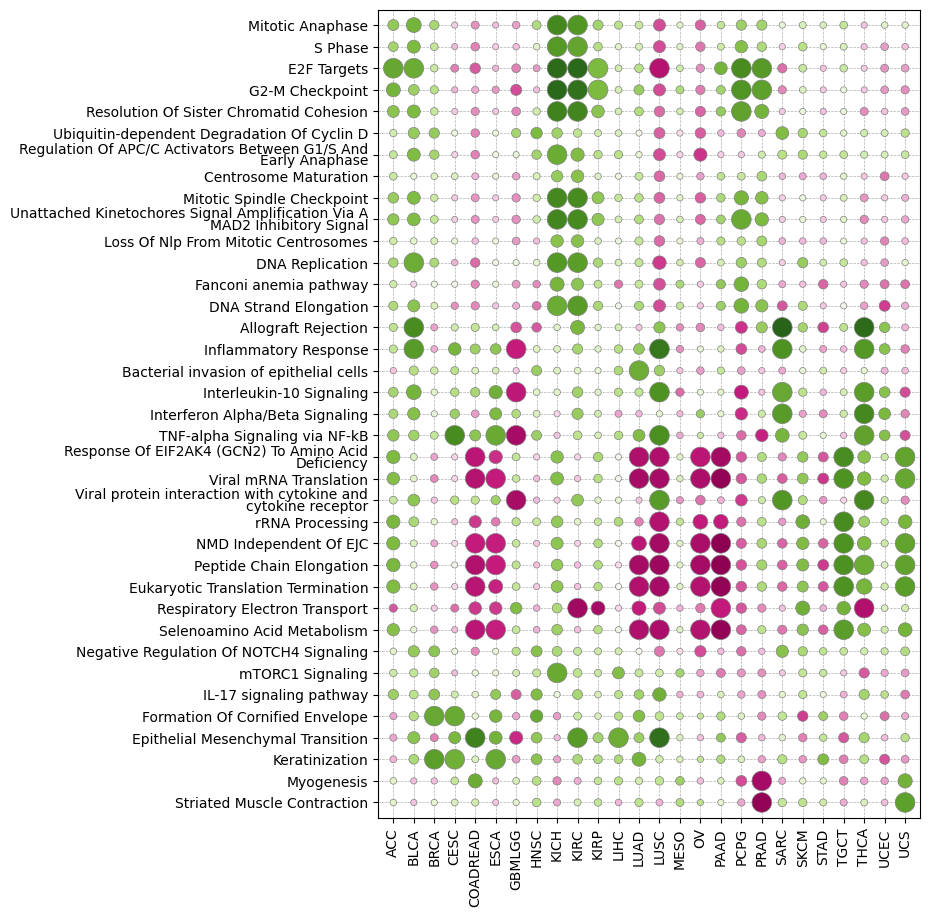

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from collections import defaultdict
from pandas.api.types import CategoricalDtype # for sorting based on the list

# Load data
temp = "Hot"
invalid_studies = ["THYM", "CHOL", "DLBC"] # ["PCPG", "UCS"]
root = "results_final_all/morphology/dseq_results"
studies = sorted([study for study in os.listdir(root) if os.path.isdir(os.path.join(root, study)) and study not in invalid_studies])
df_lists = []
lists = []

for study in studies:
    df = pd.read_csv(f"{root}/{study}/Mitotic-{temp}/gseapy.gene_set.prerank.report.csv")
    df_lists.append(df)
    lists.append(df["Term"].to_list())

# Find common names across all lists
common_names = set(lists[0])
for lst in lists[1:]:
    common_names &= set(lst)

# Create a dictionary to store the ranks of common names
name_ranks = defaultdict(list)

# Populate the dictionary with ranks from each list
for i, lst in enumerate(lists):
    for rank, name in enumerate(lst):
        if name in common_names:
            name_ranks[name].append(rank)

# Calculate the average rank for each common name
average_ranks = {name: np.mean(ranks) for name, ranks in name_ranks.items()}

# Sort the names by their average rank
sorted_names = sorted(average_ranks, key=average_ranks.get)

# # Select the top 20 names
# top_20_names = sorted_names[:20]

# top_20_names = top_20_names + mannual_pathways
# top_20_names = list(set(top_20_names))

# # manually editing all the interesting pathways
top_20_names = pathways_sorted
cat_type = CategoricalDtype(categories=top_20_names, ordered=True)
print("Top 20 common names:", top_20_names)

# Function to clean term names
def clean_term(term):
    parts = term.split("__")
    main_term = parts[1] if len(parts) > 1 else term
    if parts[0] == "Reactome_2022" and "R-HSA-" in main_term:
        main_term = main_term.split("R-HSA-")[0].strip()
    if main_term == "Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC)":
        main_term = "NMD Independent Of EJC"
    elif main_term ==  "Respiratory Electron Transport, ATP Synthesis By Chemiosmotic Coupling, Heat Production By Uncoupling Proteins":
        main_term = "Respiratory Electron Transport, ATP Synthesis"
    cleared_term = "\n".join(textwrap.wrap(main_term, width=50))
    
    return cleared_term

# Prepare data for plotting
plot_data = []

for study, df in zip(studies, df_lists):
    df_filtered = df[df["Term"].isin(top_20_names)].copy()
    
    # Convert 'Term' to the categorical type and Sort the DataFrame based on 'Term'
    df_filtered['Term'] = df_filtered['Term'].astype(cat_type)
    df_filtered = df_filtered.sort_values('Term')

    df_filtered["-log(FDR)"] = -np.log10(df_filtered["FDR q-val"].replace(0, 1e-10))
    df_filtered["Study"] = study
    df_filtered["Clean_Term"] = df_filtered["Term"].apply(clean_term)
    plot_data.append(df_filtered.sort_values(by="Clean_Term"))

plot_data = pd.concat(plot_data)
# plot_data = plot_data.sort_values(by="Clean_Term")

# Plot the dotplot
# plt.figure(figsize=(10, 6))
fig, ax =plt.subplots(1,1,figsize=(7, 10.5))
dotplot = sns.scatterplot(
    data=plot_data,
    x="Study",
    y="Clean_Term",
    size="-log(FDR)",
    hue="NES",
    palette="PiYG",
    sizes=(20, 200),
    edgecolor="gray",
    linewidth=0.5,
    ax=ax,
    legend=False
)

# Adjust line spacing for y-axis tick labels
for label in ax.get_yticklabels():
    label.set_linespacing(0.8)  # Reduce line spacing

ax.margins(y=0.02, x=0.03)

# dotplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
# plt.title('Dotplot of Top Common Terms across Studies')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_axisbelow(True)

# plt.tight_layout()

plt.savefig(f"{root}/dseq_results_{temp}_all.png", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)
# plt.savefig(f"{root}/dseq_results_complete_wide.pdf", dpi=600, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
# cold selected pathways
top_20_names_cold = ['KEGG_2021_Human__Systemic lupus erythematosus',
                     'KEGG_2021_Human__Oxidative phosphorylation',
                     'Reactome_2022__Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC) R-HSA-975956',
                     'Reactome_2022__mRNA Splicing R-HSA-72172',
                    #  'Reactome_2022__Selenocysteine Synthesis R-HSA-2408557',
                     'Reactome_2022__Negative Regulation Of NOTCH4 Signaling R-HSA-9604323',
                    #  'Reactome_2022__Respiratory Electron Transport, ATP Synthesis By Chemiosmotic Coupling, Heat Production By Uncoupling Proteins R-HSA-163200',
                     'Reactome_2022__Keratinization R-HSA-6805567',
                     'Reactome_2022__Peptide Chain Elongation R-HSA-156902',
                     'MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition',
                     'Reactome_2022__Viral mRNA Translation R-HSA-192823',
                    #  'Reactome_2022__Formation Of A Pool Of Free 40S Subunits R-HSA-72689',
                     'MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB',
                    #  'Reactome_2022__Translation R-HSA-72766',
                     'Reactome_2022__Selenoamino Acid Metabolism R-HSA-2408522',
                     'Reactome_2022__DNA Strand Elongation R-HSA-69190',
                     'Reactome_2022__S Phase R-HSA-69242',
                     'Reactome_2022__DNA Replication R-HSA-69306',
                     'MSigDB_Hallmark_2020__G2-M Checkpoint',
                    #  'Reactome_2022__Eukaryotic Translation Elongation R-HSA-156842',
                     'MSigDB_Hallmark_2020__Myogenesis',
                    #  'Reactome_2022__Processing Of Capped Intron-Containing Pre-mRNA R-HSA-72203',
                     'KEGG_2021_Human__Ribosome',
                     'MSigDB_Hallmark_2020__mTORC1 Signaling',
                     'Reactome_2022__Respiratory Electron Transport R-HSA-611105',
                     'MSigDB_Hallmark_2020__E2F Targets',
                     'Reactome_2022__Eukaryotic Translation Termination R-HSA-72764',
                     'MSigDB_Hallmark_2020__Inflammatory Response']

21

In [30]:
# hot selected pathways
top_20_names_hot = [
    'KEGG_2021_Human__Oxidative phosphorylation',
    'Reactome_2022__Selenoamino Acid Metabolism R-HSA-2408522',
    # 'KEGG_2021_Human__Regulation of lipolysis in adipocytes',
    'Reactome_2022__Respiratory Electron Transport R-HSA-611105',
    # 'MSigDB_Hallmark_2020__Interferon Gamma Response',
    'Reactome_2022__Keratinization R-HSA-6805567',
    'KEGG_2021_Human__Bacterial invasion of epithelial cells',
    'Reactome_2022__Formation Of Cornified Envelope R-HSA-6809371',
    'MSigDB_Hallmark_2020__Allograft Rejection',
    'MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition',
    'Reactome_2022__rRNA Processing R-HSA-72312',
    'MSigDB_Hallmark_2020__Interferon Alpha Response',
    'Reactome_2022__Interleukin-10 Signaling R-HSA-6783783',
    # 'Reactome_2022__Complex I Biogenesis R-HSA-6799198',
    'MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB',
    # 'Reactome_2022__Regulation Of IGF Transport And Uptake By IGFBPs R-HSA-381426',
    # 'Reactome_2022__MET Activates PTK2 Signaling R-HSA-8874081',
    # 'Reactome_2022__Formation Of A Pool Of Free 40S Subunits R-HSA-72689',
    # 'Reactome_2022__Neutrophil Degranulation R-HSA-6798695',
    'Reactome_2022__Response Of EIF2AK4 (GCN2) To Amino Acid Deficiency R-HSA-9633012',
    # 'KEGG_2021_Human__Protein processing in endoplasmic reticulum',
    # 'Reactome_2022__Collagen Biosynthesis And Modifying Enzymes R-HSA-1650814',
    'MSigDB_Hallmark_2020__G2-M Checkpoint',
    'KEGG_2021_Human__Viral protein interaction with cytokine and cytokine receptor',
    'Reactome_2022__Interferon Alpha/Beta Signaling R-HSA-909733',
    'Reactome_2022__Striated Muscle Contraction R-HSA-390522',
    'Reactome_2022__Collagen Formation R-HSA-1474290',
    # 'Reactome_2022__Extracellular Matrix Organization R-HSA-1474244',
    'MSigDB_Hallmark_2020__E2F Targets',
    'Reactome_2022__Eukaryotic Translation Termination R-HSA-72764',
    'MSigDB_Hallmark_2020__Inflammatory Response']
len(top_20_names)


21

In [31]:
# Mitotic Error related Pathways
top_20_names_known = [
'Reactome_2022__Loss Of Nlp From Mitotic Centrosomes R-HSA-380259',
'Reactome_2022__Centrosome Maturation R-HSA-380287',
'Reactome_2022__Unattached Kinetochores Signal Amplification Via A MAD2 Inhibitory Signal R-HSA-141444',
'Reactome_2022__Mitotic Anaphase R-HSA-68882',
'Reactome_2022__Regulation Of APC/C Activators Between G1/S And Early Anaphase R-HSA-176408',
'Reactome_2022__Resolution Of Sister Chromatid Cohesion R-HSA-2500257',
'Reactome_2022__Deubiquitination R-HSA-5688426',
'Reactome_2022__Ubiquitin-dependent Degradation Of Cyclin D R-HSA-75815',
'Reactome_2022__Mitotic Spindle Checkpoint R-HSA-69618',
'KEGG_2021_Human__Fanconi anemia pathway',
]

In [34]:
top_pathways_all = list(set(set(top_20_names_hot)).union(set(top_20_names_cold)).union(top_20_names_known))
len(top_pathways_all)

43

In [ ]:
pathways_sorted = [
    # Category 1: Cell Cycle and Mitosis
    'Reactome_2022__Mitotic Anaphase R-HSA-68882',
    'Reactome_2022__S Phase R-HSA-69242',
    'MSigDB_Hallmark_2020__E2F Targets',
    'MSigDB_Hallmark_2020__G2-M Checkpoint',
    'Reactome_2022__Resolution Of Sister Chromatid Cohesion R-HSA-2500257', # happens during during anaphase
    'Reactome_2022__Ubiquitin-dependent Degradation Of Cyclin D R-HSA-75815',
    'Reactome_2022__Regulation Of APC/C Activators Between G1/S And Early Anaphase R-HSA-176408',
    'Reactome_2022__Centrosome Maturation R-HSA-380287',
    'Reactome_2022__Mitotic Spindle Checkpoint R-HSA-69618',
    'Reactome_2022__Unattached Kinetochores Signal Amplification Via A MAD2 Inhibitory Signal R-HSA-141444',
    'Reactome_2022__Loss Of Nlp From Mitotic Centrosomes R-HSA-380259',

    # Category 2: DNA Replication and Repair
    'Reactome_2022__DNA Replication R-HSA-69306',
    'KEGG_2021_Human__Fanconi anemia pathway',
    'Reactome_2022__DNA Strand Elongation R-HSA-69190',
    # 'Reactome_2022__Deubiquitination R-HSA-5688426',

    # Category 3: Immune Response, Inflammation, and Viral Processes
    'MSigDB_Hallmark_2020__Allograft Rejection',
    'MSigDB_Hallmark_2020__Inflammatory Response',
    'KEGG_2021_Human__Bacterial invasion of epithelial cells',
    'Reactome_2022__Interleukin-10 Signaling R-HSA-6783783',
    'Reactome_2022__Interferon Alpha/Beta Signaling R-HSA-909733',
    'MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB',
    'Reactome_2022__Response Of EIF2AK4 (GCN2) To Amino Acid Deficiency R-HSA-9633012',
    'Reactome_2022__Viral mRNA Translation R-HSA-192823',
    'KEGG_2021_Human__Viral protein interaction with cytokine and cytokine receptor',

     # Category 4: Metabolism, Bioenergetics, and Protein Synthesis
    'Reactome_2022__rRNA Processing R-HSA-72312',
    'Reactome_2022__Nonsense Mediated Decay (NMD) Independent Of Exon Junction Complex (EJC) R-HSA-975956',
    'Reactome_2022__Peptide Chain Elongation R-HSA-156902',
    'Reactome_2022__Eukaryotic Translation Termination R-HSA-72764',
    'Reactome_2022__Respiratory Electron Transport R-HSA-611105',
    'Reactome_2022__Selenoamino Acid Metabolism R-HSA-2408522',

    # Category 6: Signaling Pathways
    'Reactome_2022__Negative Regulation Of NOTCH4 Signaling R-HSA-9604323',
    'MSigDB_Hallmark_2020__mTORC1 Signaling',
    'KEGG_2021_Human__IL-17 signaling pathway',

    # Category 6: Extracellular Matrix, Cell Adhesion, and Muscle Function
    'Reactome_2022__Formation Of Cornified Envelope R-HSA-6809371',
    'MSigDB_Hallmark_2020__Epithelial Mesenchymal Transition',
    'Reactome_2022__Keratinization R-HSA-6805567',
    'MSigDB_Hallmark_2020__Myogenesis',
    'Reactome_2022__Striated Muscle Contraction R-HSA-390522',
    
]

len(pathways_sorted)

37